In [72]:
import copy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchsummary

import utility as util

In [134]:
args = util.AttrDict(epochs=10, print_every=100, batch_size=32,
        learning_rate=0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=10)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=10)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Training set: {len(trainloader)}, {len(trainloader) * args.batch_size}")
print(f"Test set: {len(testloader)}, {len(testloader) * args.batch_size}")

Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Training set: 1563, 50016
Test set: 313, 10016


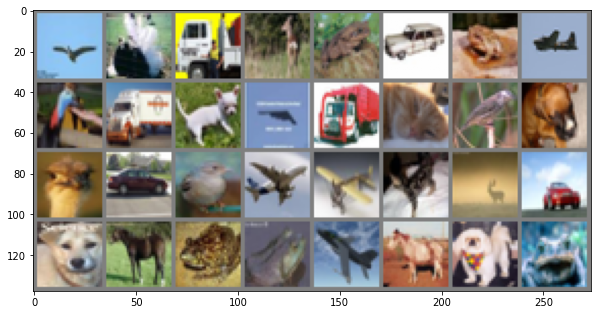

 bird  bird truck  deer  frog   car  frog plane  bird truck   dog plane truck   cat  bird   dog  bird   car  bird plane plane   cat  deer   car   dog horse  frog  frog plane horse   dog  frog


In [135]:
# functions to show an image
def imshow(img):
    # Un-normalize data.
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
# images has shape (batch size, num channels (3), hor width, ver height)
# labels has shape (batch size,)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(args.batch_size)))

In [136]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.patch_size      = config.patch_size
        self.image_channels  = config.image_channels
        self.hidden_channels = config.hidden_channels
        self.output_size     = config.output_size
        self.filters         = config.filters
        try:
            self.paddings        = config.paddings
        except:
            self.paddings = [0 for _ in self.filters]
        try:
            self.poolings        = config.poolings
        except:
            self.poolings = [None for _ in self.filters]
        self.fc_features     = config.fc_features
#         print((self.image_channels, *self.patch_size,))
        dummy = torch.ones((self.image_channels, *self.patch_size,)).unsqueeze(0) \
                * torch.tensor(float('nan'))
        conv_layers = []
        _channels = util.pairwise((self.image_channels, *self.hidden_channels,))
        print(_channels)
        for idx, ((_in_channel, _out_channel), _filter, _padding, _pool) in enumerate(
                zip(_channels, self.filters, self.paddings, self.poolings)):
            conv = nn.Conv2d(_in_channel, _out_channel, _filter, padding=_padding)
            conv_layers.append(conv)
            conv_layers.append(nn.ReLU())
            if _pool == 'max':
                pool = nn.MaxPool2d(2, 2)
                conv_layers.append(pool)
            elif _pool is None:
                pass
        self.convs = nn.Sequential(*conv_layers)
        dummy = self.convs(dummy)
        self.fc_inputs = dummy.numel()
        _features = util.pairwise((self.fc_inputs, *self.fc_features, self.output_size))
        print(_features)
        fc_layers = []
        for idx, (_in_features, _out_features) in enumerate(_features):
            fc = nn.Linear(_in_features, _out_features)
            fc_layers.append(fc)
            fc_layers.append(nn.ReLU())
        self.fcs = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x

In [148]:
# Print Summary of Model

# Base model from
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# Parameters: 206,006, (Loss: 1.0720, Accuracy: 59.32% at 5 eps, 32 bs, 0.01 lr)
base_config = util.AttrDict(
    image_channels=3,
    patch_size=[32, 32],
    hidden_channels=[6, 16],
    filters=[5, 5],
    poolings=['max', None],
    fc_features= [120, 84],
    output_size=10)

config = util.AttrDict(**base_config)

# conv-5, maxpool, 2x conv-3, maxpool
# Parameters: 77,062, (Loss: 1.4970, Accuracy: 60.02% at 5 eps, 32 bs, 0.01 lr)
def modify_1():
    config.hidden_channels = [6, 12, 24]
    config.filters = [5, 3, 3]
    config.poolings = ['max', None, 'max']
    config.fc_features = [120]
# modify_1()

# 2x conv-5, maxpool, 2x conv-3, maxpool
# Parameters: 160,630; (Loss: 0.7962; Accuracy: 67.44% at 5 eps, 32 bs, 0.01 lr)
# Parameters: 797,010; (Loss: 0.4198; Accuracy: 70.60% at 10 eps, 32 bs, 0.01 -> 0.001 -> 0.0001 lr)
def modify_2():
    config.hidden_channels = [6, 12, 24, 48]
    config.filters = [5, 5, 3, 3]
    config.paddings = [1, 1, 0, 0]
    config.poolings = [None, 'max', None, 'max']
    config.fc_features = [120]
modify_2()

# Increasing the FCdoesn't improve much
# Parameters: 797,010; (Loss: 0.3222; Accuracy: 71.40% at 10 eps, 32 bs, 0.01 -> 0.001 -> 0.0001 lr)
def modify_3():
    config.hidden_channels = [6, 12, 24, 48]
    config.filters = [5, 5, 3, 3]
    config.paddings = [1, 1, 0, 0]
    config.poolings = [None, 'max', None, 'max']
    config.fc_features = [600, 100]
# modify_3()

net = Net(config).to(device)
torchsummary.summary(net, (3, 32, 32))

[(3, 6), (6, 12), (12, 24), (24, 48)]
[(1200, 120), (120, 10)]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             456
              ReLU-2            [-1, 6, 30, 30]               0
            Conv2d-3           [-1, 12, 28, 28]           1,812
              ReLU-4           [-1, 12, 28, 28]               0
         MaxPool2d-5           [-1, 12, 14, 14]               0
            Conv2d-6           [-1, 24, 12, 12]           2,616
              ReLU-7           [-1, 24, 12, 12]               0
            Conv2d-8           [-1, 48, 10, 10]          10,416
              ReLU-9           [-1, 48, 10, 10]               0
        MaxPool2d-10             [-1, 48, 5, 5]               0
           Linear-11                  [-1, 120]         144,120
             ReLU-12                  [-1, 120]               0
           Linear-13                   [

[(3, 6), (6, 12), (12, 24), (24, 48)]
[(1200, 120), (120, 10)]



Accuracy: 40.24%



Accuracy: 53.13%



Accuracy: 58.43%



Accuracy: 61.32%



Accuracy: 64.97%



Accuracy: 70.48%



Accuracy: 70.70%



Accuracy: 70.52%



Accuracy: 70.77%



Accuracy: 70.60%
Done.


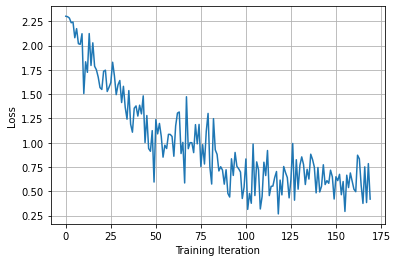

In [149]:
loss_over_time = []
def train(net, args, trainloader, testloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=0.9)
#     optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)
#     scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    scheduler = None
    
    for epoch in range(1, args.epochs + 1):
        prefix = f"Training Epoch {epoch}: "
        pbar = tqdm(trainloader, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0)
        
        if epoch == 6:
            for g in optimizer.param_groups:
                g['lr'] = 0.001
        if epoch == 7:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        for iteration, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if iteration % args.print_every == 0 or iteration == len(trainloader)-1:
                pbar.set_description("Training epoch {} (loss {:9.4f}): ".format(epoch, loss.item()))
                pbar.update()
                loss_over_time.append(loss.item())
        correct = 0
        total = 0
        with torch.no_grad():
            net.eval()
            prefix = f"Evaluating: "
            for inputs, labels in tqdm(testloader, desc=prefix,
                        dynamic_ncols=True, leave=True, position=0):
                inputs, labels = inputs.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(inputs)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            net.train()
        print("Accuracy: {:1.2%}".format(correct / total))
    print("Done.")

net = Net(config).to(device)
should_create_new_instance = True
if should_create_new_instance:
    train(net, args, trainloader, testloader)
    torch.save(net.state_dict(), './models/cifar_net.pth')
    plt.plot(range(len(loss_over_time)), loss_over_time)
    ax = plt.gca()
    ax.set_ylabel("Loss")
    ax.set_xlabel("Training Iteration")
    ax.grid()
else:
    net.load_state_dict(torch.load('./models/cifar_net.pth'))

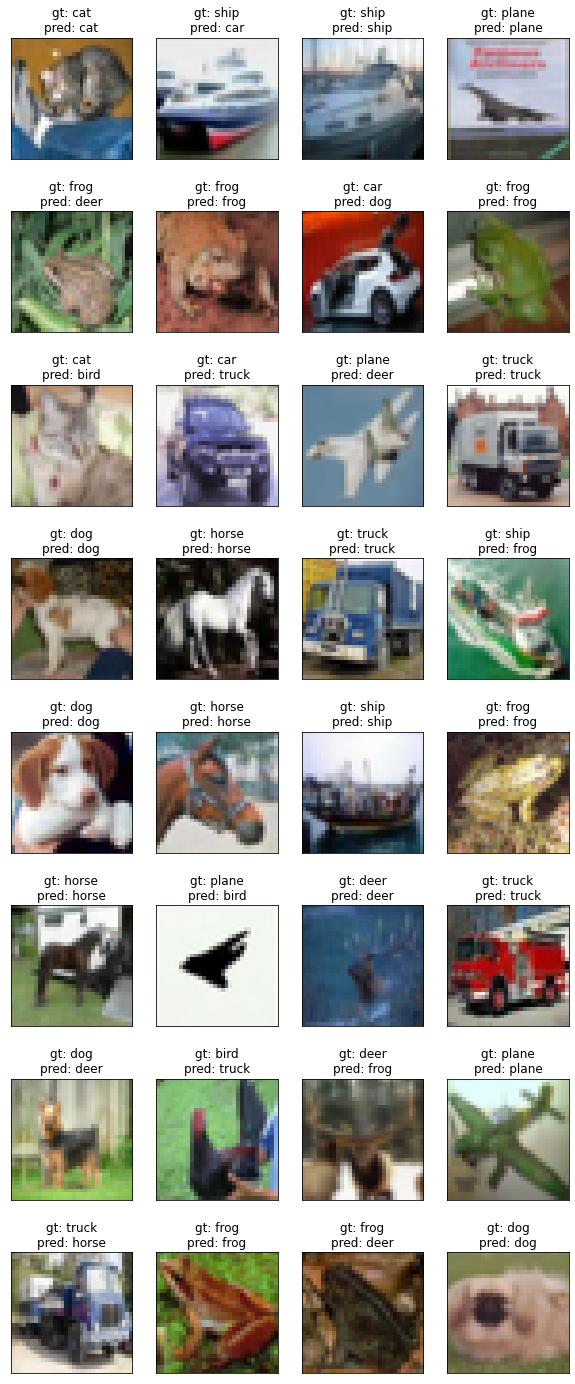

In [143]:
dataiter = iter(testloader)
images, labels = dataiter.next()

_images = images.to(device)
outputs = net(_images)
_, predicted = torch.max(outputs, 1)

# print images
# imshow(torchvision.utils.make_grid(images))
# get labels
ground_truth = [classes[labels[j]] for j in range(args.batch_size)]
predictions = [classes[predicted[j]] for j in range(args.batch_size)]

df = pd.DataFrame({
    'GroundTruth': ground_truth,
    'Prediction': predictions
})

images = images.numpy()
n_rows = args.batch_size // 4 + int((args.batch_size % 4) > 0)
fig, axes = plt.subplots(n_rows, 4, figsize=(10, 25))
axes = axes.ravel()
for idx, image in enumerate(images):
    image = image / 2 + 0.5
    image = image.transpose((1, 2, 0))
    axes[idx].imshow(image)
    title = "gt: {}\npred: {}".format(df.at[idx, 'GroundTruth'], df.at[idx, 'Prediction'])
    axes[idx].set_title(title)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [49]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 54 %


In [50]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    net.eval()
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    net.train()


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))


Accuracy for class plane is: 66.2 %
Accuracy for class car   is: 72.9 %
Accuracy for class bird  is: 30.7 %
Accuracy for class cat   is: 11.5 %
Accuracy for class deer  is: 61.6 %
Accuracy for class dog   is: 57.8 %
Accuracy for class frog  is: 61.7 %
Accuracy for class horse is: 62.8 %
Accuracy for class ship  is: 56.7 %
Accuracy for class truck is: 62.0 %
